## 0. Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import countergen

## 1. Choose your dataset
Put your file next to the notebook and give it's filename here:

[Box where you can put your filename, with a convincing default dataset]

[Check that it exists]

[Print a few samples]

In [3]:
ds = countergen.Dataset.from_default("doublebind")

## 2. Choose your augmenters

[Checkboxes with title and explanation]

[Link to somewhere if you want to add your own augmenters]

In [4]:
augmenters = [countergen.SimpleAugmenter.from_default("gender")]

## 3. Convert!

(Just run this cell)

In [5]:
aug_ds = ds.augment(augmenters)

100%|██████████| 9/9 [00:00<00:00, 2015.42it/s]


## 4. Choose models to evaluate

[Checkboxs of different models compatible with the dataset you have chosen]

[Link to somewhere if you want to evaluate other models]

In [6]:
from countergentorch.evaluation import get_generative_model_evaluator, pt_to_generative_model
from countergentorch.tools.utils import get_device
from transformers import GPT2LMHeadModel
import torch

model_names = ["distilgpt2"]
device = get_device()
model: torch.nn.Module = GPT2LMHeadModel.from_pretrained(model_names[0]).to(device)
model_ev = get_generative_model_evaluator(pt_to_generative_model(model), "probability")

## 4b. Choose your metrics

[Checkboxs of different metrics & aggregation methods]

[Link to somewhere if you want to add your own]

In [10]:
aggregator = countergen.aggregators.PerformanceStatsPerCategory()

## 5. Evaluate!

(Just run this cell)

In [11]:
results = countergen.evaluate(aug_ds.samples, model_ev, aggregator)

100%|██████████| 9/9 [00:03<00:00,  2.32it/s]


## 6. The results

[Beautiful displays]

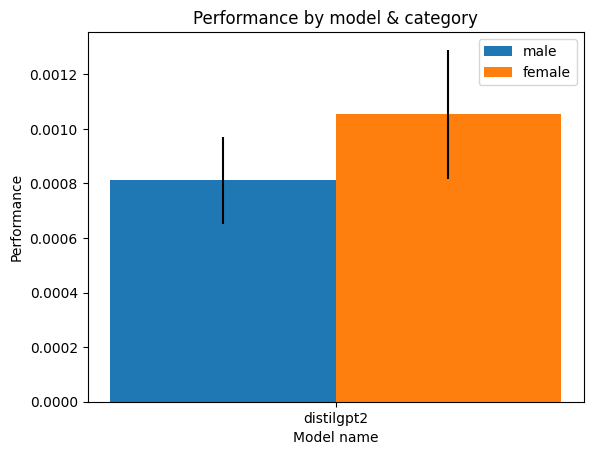

In [12]:
aggregator.display({"distilgpt2":results})

## 7. Edit...

In [14]:
from countergentorch.editing import ActivationsDataset, get_mlp_modules
layers_dict = get_mlp_modules(model, [2,3])
layers = list(layers_dict.values())
act_ds = ActivationsDataset.from_augmented_samples(aug_ds.samples, model, layers)

In [15]:
from countergentorch.editing.direction_algos import inlp
dirs = inlp(act_ds, n_training_iters=10)

100%|██████████| 10/10 [00:00<00:00, 10.99it/s, accuracy=0.495, loss=12.1]
c:\Other\Anaconda\envs\seven\lib\site-packages\torch\testing\_deprecated.py:35: FutureWarning: torch.testing.assert_allclose() is deprecated since 1.12 and will be removed in 1.14. Use torch.testing.assert_close() instead. For detailed upgrade instructions see https://github.com/pytorch/pytorch/issues/61844.
  warnings.warn(msg, FutureWarning)
100%|██████████| 8/8 [00:07<00:00,  1.07it/s, accuracy=0.495, loss=12.2]


In [16]:
from countergentorch.editing import edit_model, get_edit_configs
configs = get_edit_configs(layers_dict, dirs, has_leftover=False)
new_model = edit_model(model, configs=configs)

100%|██████████| 9/9 [00:03<00:00,  2.36it/s]


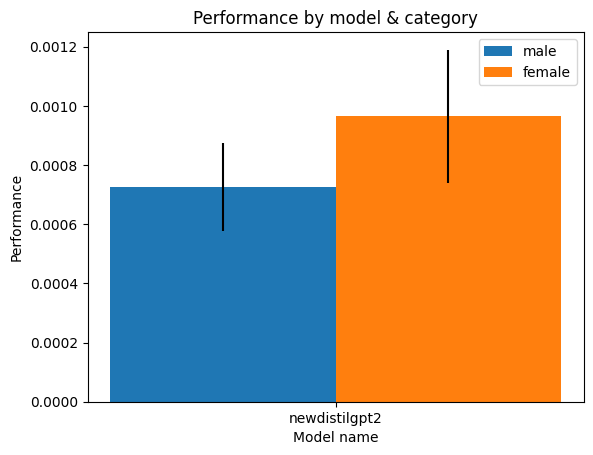

In [17]:
new_model_ev = get_generative_model_evaluator(pt_to_generative_model(new_model), "probability")
new_results = countergen.evaluate(aug_ds.samples, new_model_ev, aggregator)
aggregator.display({"newdistilgpt2":new_results})

In [18]:
from countergentorch.editing.direction_algos import rlace
dirs = rlace(act_ds, n_dim=2, out_iters=100, num_clfs_in_eval=1, evalaute_every=50)

50/100. Acc post-projection: 98.025%; best so-far: 97.786%; Maj: 50.545%; Gap: 47.241%; best loss: 0.2892; current loss: 0.2892: 100%|##########| 100/100 [00:11<00:00,  8.59it/s]


In [19]:
from countergentorch.editing import edit_model, get_edit_configs
configs = get_edit_configs(layers_dict, dirs, has_leftover=False)
new_model = edit_model(model, configs=configs)

100%|██████████| 9/9 [00:04<00:00,  2.04it/s]


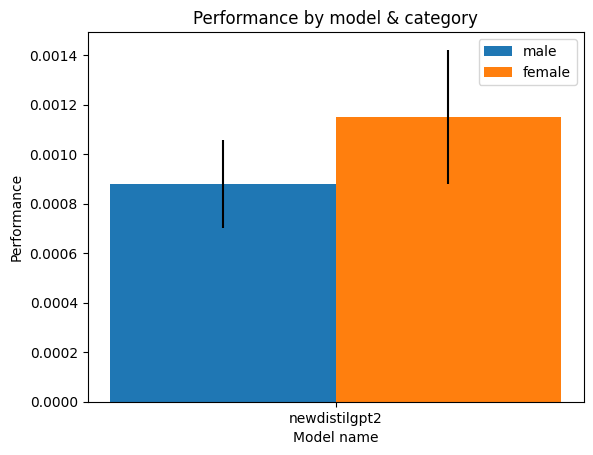

In [20]:
new_model_ev = get_generative_model_evaluator(pt_to_generative_model(new_model), "probability")
new_results = countergen.evaluate(aug_ds.samples, new_model_ev, aggregator)
aggregator.display({"newdistilgpt2":new_results})